In [1]:
# Basic
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import pinv2
from tqdm import tqdm

# For Dataset
from collections import deque, namedtuple
import random

# For solvers
from qpsolvers import solve_qp
from scipy.integrate import solve_ivp
from casadi import *
import casadi

# For estimators
from torch import nn
import torch
import torch.nn.functional as F




In [3]:
from utils.system import AAC
from utils.controller import LCBF, PID
from utils.dataset import Dataset
from utils.estimator import *

In [4]:
def sample_initial_state(p_min = 0, p_max = 2,
                         v_min = 18, v_max = 22,
                         z_min = 38, z_max = 42):
    p0 = np.random.uniform(p_min, p_max)
    v0 = np.random.uniform(v_min, v_max)
    z0 = np.random.uniform(z_min, z_max)
    return np.array([p0, v0, z0])

class Derivator:
    def __init__(self, dt):
        self.x = 0
        self.dt = dt
        
    def update(self, x_n):
        dx = (x_n - self.x)/dt
        
        self.x = x_n
        
        
        return dx
    

In [5]:
dt = 0.01
simTime = 50

# Real parameters
v_lead = 22
v_des = 24
m  = 1650.0
g = 9.81

# 
f0 = 0.1
f1 = 5
f2 = 0.25
#

c_a = 0.3
c_d = 0.3
Th = 1.8

# Nominal parameters
f0_nom = 10*f0
f1_nom = 10*f1
f2_nom = 10*f2

p_slack = 2e-2
clf_rate = 5
cbf_rate = 5.

# Initial state
p0 = 0.
v0 = 22
z0 = 35


x_lst = []
u_lst = []
V_lst = []
B_lst = []
slack_lst = []

# Parameter ELM
n_hidden = 50


In [9]:
aac = AAC(m, c_d, f0, f1, f2, v_lead)

cont = LCBF(m, c_a, c_d, f0_nom, f1_nom, f2_nom, v_lead, v_des, Th, clf_rate, cbf_rate, p_slack)

derivator = Derivator(dt)

learned_ratio = 1.6
estimator = OSELM_affine_2head(3, n_hidden, 2, learned_ratio, dt) #OSELM_affine(3, n_hidden, 2, learned_ratio, dt)

# e_f, e_g

xs = []
us = []
Vs = []
hs = []
dhe_reals = []
dhes = []

# Temporal
e_f_reals = []
e_f_ests = []
e_f_mins = []

e_g_reals = []
e_g_ests = []
e_g_mins = []

slacks = []

weights = 0.2

train_input, train_output = [], []

x = sample_initial_state()

first_time = True

# PID control reference
x_dim = 3
u_dim = 1

kp = np.array([[0, 1.0e3, 0]])
kd = np.array([[0, 0.1, 0]])
ki = np.array([[0, 1.0e3, 0]])

pid = PID(x_dim, u_dim, kp, kd, ki, dt)

if simTime / dt < learned_ratio*n_hidden:
    raise ValueError('simTime / dT: {} must be larger than {} times the n_hidden: {}'.format(simTime / dt, learned_ratio,n_hidden))

pbar = tqdm(total=simTime/dt)

for t in np.arange(0, simTime, dt): #simTime
    pbar.update(n=1)
    
    # Get reference control
    e = np.array([[0], [v_des], [0]]) - np.expand_dims(x, axis = 1)
    u_ref = pid.update(e) #f0_nom * v**2 + f1_nom * v + f2_nom
    u_ref = u_ref[0,0]
    
    aac.v_lead = v_lead # + 5*np.sin(2*t) # lead_vehicle
    cont.v_lead =  v_lead # + 5*np.sin(2*t)
    
    # Control Input

    x_tmp = np.array(x)
    #x_tmp[0] = 0

    k, slack_sol, V, dV, h, dh, dhe, dS = cont.compute_controller(x_tmp, u_ref, estimator, weights, t) 


    # One step propagation in the system
    x_n = aac.update(x, k, t, dt)

    dh_real = derivator.update(h)

    dhe_real = dh_real - dh

    

    # Temporal
    v = x[1]
    v_lead_real = v_lead  #+ 5*np.sin(2*t)
    Fr_real = f0 * v**2 + f1 * v + f2
    L_f_h_real = (Fr_real)/m * (Th + (v - v_lead_real)/c_d/g ) + (v_lead_real - v)
    L_g_h_real = - 1/m * (Th + (v - v_lead_real)/c_d/g )

    Fr_nom = f0_nom * v**2 + f1_nom * v + f2_nom
    L_f_h_nom = (Fr_nom)/m * (Th + (v - v_lead)/c_d/g ) + (v_lead - v)
    L_g_h_nom = - 1/m * (Th + (v - v_lead)/c_d/g )

    e_f_real = L_f_h_real - L_f_h_nom
    e_g_real =  L_g_h_real - L_g_h_nom


    


    #e_fg_est, _ = estimator.e_fg.predict(np.array([x]))
    e_f_est, _ = estimator.e_f.predict(np.array([x_tmp]))# e_fg_est[0,0]
    e_g_est, _ = estimator.e_g.predict(np.array([x_tmp])) #e_fg_est[0,1] 

    #print(e_f_est)

    e_fg_min = (pinv2(np.array([[1, k]])) * dhe_real).squeeze()
    e_f_min = e_fg_min[0]
    e_g_min = e_fg_min[1]


    # Training
    estimator.training(x_tmp, k, dhe_real, t, e_f_real, e_g_real, True)

    xs.append(x)
    us.append(k)
    Vs.append(V)
    hs.append(h)
    dhes.append(dhe)
    dhe_reals.append(dhe_real)
    slacks.append(slack_sol)

    # Temporal
    e_f_reals.append(e_f_real)
    e_f_ests.append(e_f_est)
    e_f_mins.append(e_f_min)

    e_g_reals.append(e_g_real)
    e_g_ests.append(e_g_est)
    e_g_mins.append(e_g_min)

    x = x_n
        
pbar.close()


 28%|██▊       | 1383/5000.0 [00:13<00:35, 101.76it/s]/home/emanuelsamir/Documentos/dev/RISS/state-of-the-art/LCBF-CLF/notebook/utils/estimator.py:130: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
100%|██████████| 5000/5000.0 [00:46<00:00, 107.66it/s]


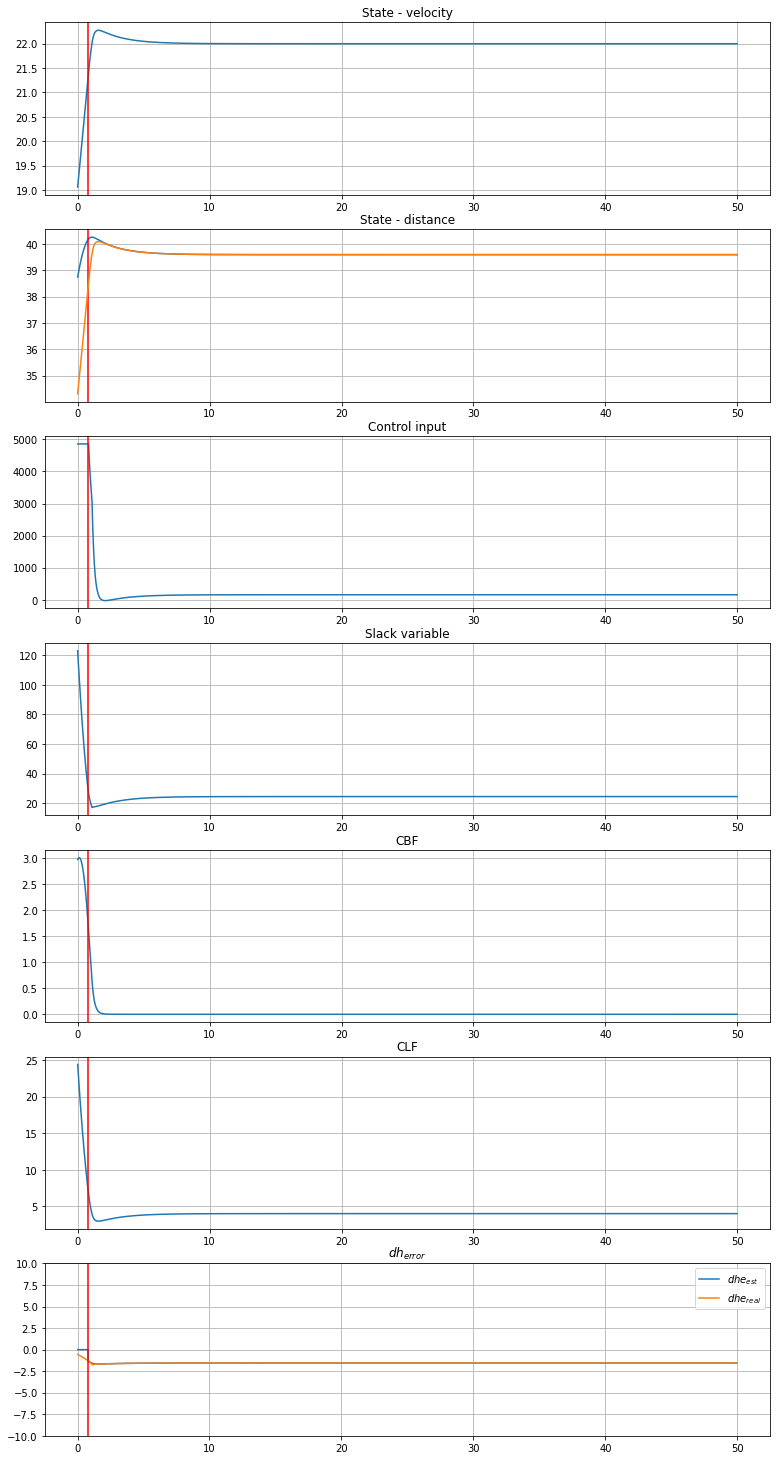

In [10]:
f,ax = plt.subplots(7,1,figsize = (13,26))
t_lns = np.arange(0, simTime, dt)

ax[0].plot(t_lns, np.array(xs)[:,1])
ax[0].grid(True)
ax[0].set_title('State - velocity')
ax[0].axvline(x = n_hidden*learned_ratio*dt, color = 'red')

ax[1].plot(t_lns,  np.array(xs)[:,2])
ax[1].grid(True)
ax[1].set_title('State - distance')
ax[1].axvline(x = n_hidden*learned_ratio*dt, color = 'red')

ax[1].plot(t_lns, Th*np.array(xs)[:,1])#  + 0.5*(np.array(x_lst)[exp,:,1] - v_ego)/c_d/g)

ax[2].plot(t_lns,  np.array(us))
ax[2].grid(True)
ax[2].set_title('Control input')
ax[2].axvline(x = n_hidden*learned_ratio*dt, color = 'red')


ax[3].plot(t_lns, np.array(slacks))
ax[3].grid(True)
ax[3].set_title('Slack variable')
ax[3].axvline(x = n_hidden*learned_ratio*dt, color = 'red')


ax[4].plot(t_lns, hs)
ax[4].axvline(x = n_hidden*learned_ratio*dt, color = 'red')
ax[4].grid(True)
ax[4].set_title('CBF')

ax[5].plot(t_lns, Vs)
ax[5].axvline(x = n_hidden*learned_ratio*dt, color = 'red')
ax[5].grid(True)
ax[5].set_title('CLF')

ax[6].plot(t_lns[1:], dhes[1:])
ax[6].plot(t_lns[1:], dhe_reals[1:])
ax[6].grid(True)
ax[6].set_title('$dh_{error}$')
ax[6].axvline(x = n_hidden*learned_ratio*dt, color = 'red')


ax[6].set_ylim([-10,10])
ax[6].legend(['$dhe_{est}$','$dhe_{real}$'])


/home/emanuelsamir/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.
/home/emanuelsamir/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


(-0.005, 0.005)

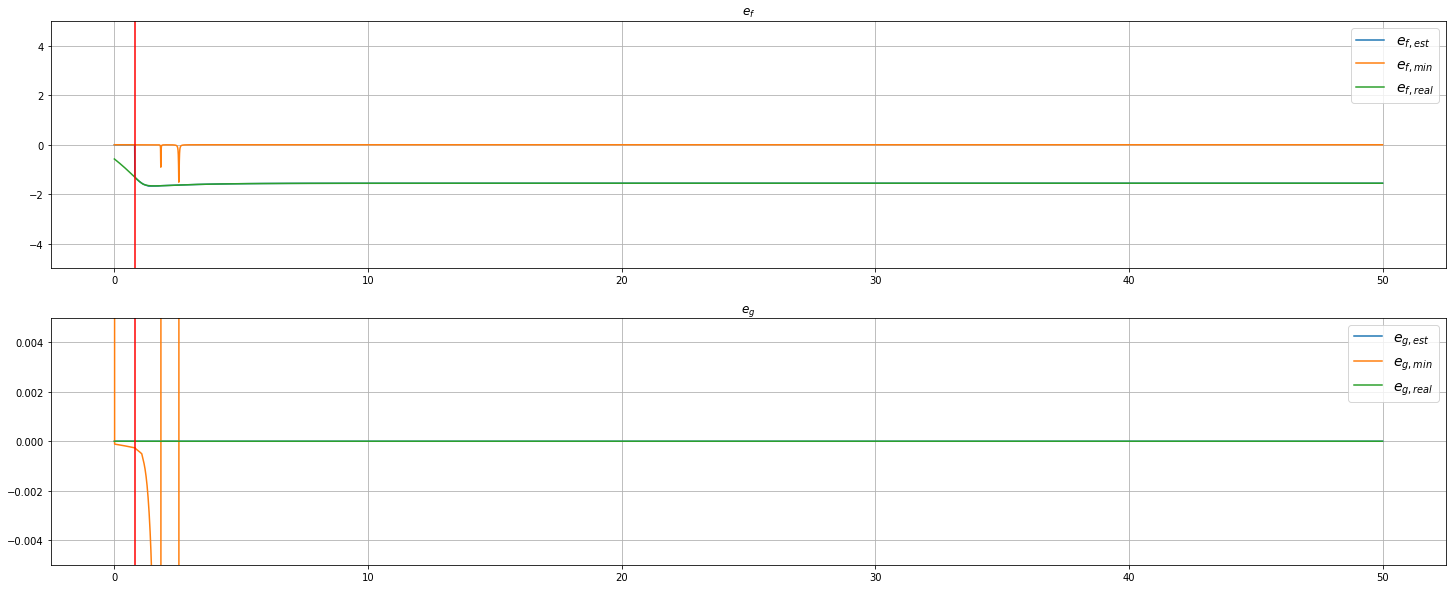

In [12]:
f,ax = plt.subplots(2,1,figsize = (25,10))
t_lns = np.arange(0, simTime, dt)

ax[0].plot(t_lns, np.array(e_f_ests))
ax[0].plot(t_lns, np.array(e_f_mins))
ax[0].plot(t_lns, np.array(e_f_reals))
ax[0].axvline(x = n_hidden*learned_ratio*dt, color = 'red')

ax[0].grid(True)
ax[0].set_title('$e_f$')
ax[0].legend(['$e_{f,est}$','$e_{f,min}$','$e_{f,real}$'], fontsize =14)
ax[0].set_ylim([-5,5])
#ax[0].set_ylim([-0.0001,0.0001])

ax[1].plot(t_lns, np.array(e_g_ests))
ax[1].plot(t_lns, np.array(e_g_mins))
ax[1].plot(t_lns, np.array(e_g_reals))
ax[1].axvline(x = n_hidden*learned_ratio*dt, color = 'red')

ax[1].grid(True)
ax[1].set_title('$e_g$')
ax[1].legend(['$e_{g,est}$','$e_{g,min}$','$e_{g,real}$'], fontsize =14)
ax[1].set_ylim([-0.005,0.005])

## Simplest case

In [3]:
A = np.array([[1, 5000]]) # A = [1, u]
efg = np.array([[0.3], [0.4]]) # efg = []
my_dh_real = np.dot(A, efg)

# Inverse process: efg not known
efg_est = np.dot(pinv2(A), my_dh_real)
my_dh_est = np.dot(A, efg_est)




In [4]:
u_ext = np.array([[1, 5000]])
# dhe = dh + dhx * (eps_f + eps_g*u)
# dVe =  dV + dVx * (eps_f + eps_g*u)
# pinv(dVx) * (dVe - dV) = (eps_f + eps_g*u)

# dhx * pinv(dVx) * (dVe - dV) = dhx * (eps_f + eps_g*u)
# dhe - dh = dhx * (eps_f + eps_g*u)

# [[1, k],[1, k]] * [[e_f],[e_g]]





In [5]:
u_ext = np.array([[1, 5000]])

dhx = np.array([[0, -1, 2]])
dVx = np.array([[0, 2, 0]])
dh = np.array([[2500]])
dV = np.array([[1000]])

eps_fg = np.array([[0.5],[0.6]])




In [6]:
dh_real = dh + dhx * np.dot(u_ext, eps_fg)
dV_real =  dV + dVx * np.dot(u_ext, eps_fg)



$$
\frac{\partial h}{\partial x} \left( \frac{\partial V}{\partial x} \right)^+ \tilde{\dot{V}} = \tilde{\dot{h}}_1 = \frac{\partial h}{\partial x} [ \tilde{f} \; \tilde{g}] [1 \; u]^T \\
\tilde{\dot{h}} = \tilde{\dot{h}}_2 = \frac{\partial h}{\partial x} [ \tilde{f} \; \tilde{g}] [1 \; u]^T
$$

A possible arrangement could be

$$
\frac{\partial h}{\partial x} [ \tilde{f} \; \tilde{g}]  = [e_f \; e_g] = [\tilde{\dot{h}}_1  \; \tilde{\dot{h}}_2 ] \begin{bmatrix} 1& 1\\ u &u
\end{bmatrix}^+
$$


In [54]:

# Random sample values for the components.
u_ext = np.array([[1], [5000]])

dhx = np.array([[0, -1, 2]])
dVx = np.array([[0, 2, 0]])
dh_est = np.array([[3]])
dV_est = np.array([[4]])

eps_fg = np.array([[0.5,0.2],[0.6,0.1],[0.1,0.4]]) # [eps_f eps_g]


dh_real = dh_est + dhx.dot(np.dot(eps_fg, u_ext))
dV_real =  dV_est + dVx.dot(np.dot(eps_fg, u_ext))

dhe1 = dh_real - dh_est
dhe2 = dhx.dot(pinv(dVx)).dot(dV_real - dV_est) 

U = np.hstack([u_ext,u_ext])
Y = np.hstack([dhe1,dhe2])

#e_fg = [e_f, e_g]
e_fg_real = dhx.dot(eps_fg) 
e_fg_est = Y.dot(pinv2(U)) # if pinv2 replaced with pinv, NaN error appears

print('Values expected {}'.format(e_fg_real))
print('Values obtained {}'.format(e_fg_est))



Values expected [[-0.4  0.7]]
Values obtained [[5.99799976e-05 2.99899988e-01]]


In [60]:
e_fg_real.dot(u_ext)

array([[3499.6]])

In [59]:
e_fg_est.dot(u_ext)

array([[1499.5]])

In [63]:
Y

array([[3499.6, -500.6]])

In [19]:
A = np.array([[1, 5000],[1, 5000]]) 

In [22]:
pinv2(A)

array([[3.99999984e-08],
       [1.99999992e-04]])

In [14]:
pinv2(A)

array([[1.99999992e-08, 1.99999992e-08],
       [9.99999960e-05, 9.99999960e-05]])

In [4]:
efg_est

array([[8.00119968e-05],
       [4.00059984e-01]])

In [5]:
efg

array([[0.3],
       [0.4]])

In [6]:
my_dh_est

array([[2000.3]])

In [7]:
my_dh_real

array([[2000.3]])